# import Library

In [1]:
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
import time
from collections import defaultdict
from collections import namedtuple
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import io
import re
from collections import namedtuple
from collections import deque
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image
import matplotlib.pyplot as plt
import random
# from mylibrary.fnframework import FNAgent,Environment,Action,Trainer
from mylibrary.plottrade import PlotTrade
from mylibrary.maketraindata import MakeTrainData
import xgboost as xgb
from sklearn.metrics import accuracy_score  
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, accuracy_score,roc_curve, roc_auc_score
import pickle
import datetime
from sklearn import preprocessing
from sklearn.metrics import r2_score
import copy
import optuna
from keras.callbacks import EarlyStopping

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# path ubu

In [2]:
path_daw = '/home/hipro/デスクトップ/StockPriceData/Stock_index/DAW_10years.csv'
path_tpx = '/home/hipro/デスクトップ/StockPriceData/Stock_index/TOPIX_10years.csv'


# path mac

In [2]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/rince/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

# path win

In [9]:
path_tpx = '/Users/Owner/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/Owner/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/Owner/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/Owner/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

# funcs

In [3]:
def xgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {'objective':'binary:logistic', 
                  'eta': 0.09596830907961507, 
                  'max_depth': 3,
                  'lambda': 0.7357580506094586,
                  'n_estimators': 3,
                  'reg_alpha': 0.6480353642599526, 
                  'reg_lambda': 0.48699139703134453,
                  'importance_type': 'total_cover',
                  'use_label_encoder':False}
    
    param_def = {'objective':'binary:logistic','use_label_encoder':False}
    xgb_model = xgb.XGBClassifier(**param_dist)
    hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    print("---------------------")
    y_proba_train = xgb_model.predict_proba(x_train)[:,1]
    y_proba = xgb_model.predict_proba(x_test)[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    xgb.plot_importance(xgb_model) 
    return xgb_model

def for_xgb_data(path_tpx, path_daw):
    df_tpx = DataFramePreProcessing(path_tpx).load_df()
    df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
    daw_p = df_daw.pct_change()
    df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
    df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
    return df_tmp

def make_x_train(path_tpx, path_daw):
    df_tpx  = DataFramePreProcessing(path_tpx).load_df()
    df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
    daw_p = df_daw['dclose'].pct_change()
    tpx_p = df_tpx['close'].pct_change()

    df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
    df_tmp = df_con.rename(columns={'close': 'pclose'})
    df_tmp = pd.concat([df_tmp,df_tpx['close']],axis = 1,join='inner').astype(float)

    x_train = df_tmp.loc[:,['dclose','pclose']].iloc[1:]
    price_chart = df_tmp['close'].iloc[1:]
    return x_train, price_chart

def make_x_train2(state_, chart_, path_tpx, path_daw):
    df_state = pd.DataFrame(state_)
    df_state['day'] = chart_.index
    df_state.reset_index(inplace=True)
    df_state.set_index('day',inplace=True)
    df_state.drop('index',axis=1,inplace=True)
    
    x_train, _ = make_x_train(path_tpx, path_daw)
    x_train = pd.concat([x_train,df_state],axis = 1,join='inner').astype(float)
    
    return x_train, chart_

def predict_tomorrow(lq,folder_name):
    path_ = '/Users/rince/Desktop/StockPriceData/%s/*.csv' % folder_name
    file = glob.glob(path_)
    path_tpx = sorted(file)[-1]
    path_ = '/Users/rince/Desktop/StockPriceData/DAW/*.csv'
    file = glob.glob(path_)
    path_daw = sorted(file)[-1]
    lq.predict_tomorrow(path_tpx,path_daw)
    
def plot(g,label=''):
#     type(g) = pd.DataFrame
    plt.subplots(figsize=(10, 6))
    plt.fill_between(g.index,y1 = g['ma'] - g['std'],y2=g['ma']+g['std'],alpha=0.3)
    plt.plot(g.index,g['ma'],label=label)
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.grid(True)
    
def make_plot_data(reward_log, ma=5):
#     type(reward_log)==list

    length = len(reward_log)
    reward_log = np.array(reward_log)
    reward_dict = {}
    if ma%2==0:
        print("ma must be odd number.")
        return 
    
    
    sride = ma//2
    try:
        for i in range(sride,length-sride):
            reward_dict[i] = {'reward':reward_log[i],'ma':reward_log[i-sride:i+sride+1].mean(),
                             'std':reward_log[i-sride:i+sride+1].std()}
    except:
        print("Error.")
    
    return pd.DataFrame(reward_dict).T
     
def easy_plot(df,xlabel='episode',ylabel='reward'):
    plt.subplots(figsize=(10, 6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.plot(df)
    plt.show()
    
def make_df_con(path_tpx,path_daw):
    df_tpx = DataFramePreProcessing(path_tpx).load_df()
    df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
    daw_p = df_daw.pct_change()
    df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
    df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
    return df_tmp

def grid_search(x_train,y_train,x_test,y_test):
    trains = xgb.DMatrix(x_train.astype(float), label=y_train)
    tests = xgb.DMatrix(x_test.astype(float), label=y_test)

    base_params = {
        'booster': 'gbtree',
        'objective':'binary:logistic',
        'eval_metric': 'rmse',
        'random_state':100,
        'use_label_encoder':False
    }

    watchlist = [(trains, 'train'), (tests, 'eval')]
    tmp_params = copy.deepcopy(base_params)
    
#     インナー関数
    def optimizer(trial):
        eta = trial.suggest_uniform('eta', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        __lambda = trial.suggest_uniform('lambda', 0.7, 2)
        n_estimators = trial.suggest_int('n_estimators', 3, 20)
        learning_rate = trial.suggest_uniform('lambda', 0.01, 1)
        reg_alpha = trial.suggest_uniform('reg_alpha', 0.01, 1)
        reg_lambda = trial.suggest_uniform('reg_lambda', 0.01, 1)
        importance_type = trial.suggest_categorical('importance_type',
                                                    ['gain', 'weight', 'cover','total_gain','total_cover'])

        tmp_params['eta'] = eta
        tmp_params['max_depth'] = max_depth
        tmp_params['lambda'] = __lambda
        tmp_params['n_estimators'] = n_estimators
        tmp_params['learning_rate'] = learning_rate
        tmp_params['reg_alpha'] = reg_alpha
        tmp_params['reg_lambda'] = reg_lambda
        tmp_params['importance_type'] = importance_type
        model = xgb.train(tmp_params, trains, num_boost_round=50)
        predicts = model.predict(tests)
        r2 = r2_score(y_test, predicts)
        print(f'#{trial.number}, Result: {r2}, {trial.params}')
        return r2
    
    study = optuna.create_study(direction='maximize')
    study.optimize(optimizer, n_trials=500)
    print(study.best_params)
    print(study.best_value)

    

# classes

In [10]:
Experience = namedtuple("Experience", ["s","a","r","n_s","n_a","d"])

class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)
    
class PlotTrade():
    
    
    def __init__(self, df_chart,label=''):
        self.df_chart = df_chart
        plt.clf()
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.ax.plot(self.df_chart,label=label)
        plt.legend()
        
    def add_span(self, start_time,end_time):
        self.ax.axvspan(start_time, end_time, color="gray", alpha=0.3)
        
    
    def add_plot(self, df_plot,label=''):
        self.ax.plot(df_plot,label=label)
        plt.legend()
        
        
    def show(self):
        self.ax.grid()
        labels = self.ax.get_xticklabels()
        plt.setp(labels, rotation=15, fontsize=12)
        plt.show()
         
class ValidatePlot(PlotTrade):
    
    
    def __init__(self, df_chart, is_validate=False):
        pass
        
    def add_span(self, start_time,end_time):
        pass
        
    
    def add_plot(self, df_plot):
        pass
        
        
    def show(self):
        pass
    
class XGBSimulation():
    
    
    def __init__(self, xgb_model, alpha=0.70):
        self.xgb_model = xgb_model
        self.alpha = alpha
        
    
    def make_df_con(self, path_tpx,path_daw):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
        daw_p = df_daw.pct_change()
        df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
        df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
        return df_tmp
    
    
    def make_check_data(self,path_tpx,path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)
        mk = MakeTrainData(df_con,test_rate=1.0)
        x_check, y_check, x_dummy, y_dummy = mk.make_data()
        self.ma_short = mk.ma_short
        self.ma_long = mk.ma_long
        return x_check, y_check
    
    
    def eval_proba(self, x_test, y_test):
        predict_proba = self.xgb_model.predict_proba(x_test.astype(float))
        df = pd.DataFrame(columns = ['score','Up precision','Down precision','Up recall','Down recall','num'])
        j=0
        acc_dict = {'TU':0,'FU':0,'TD':0,'FD':0}
        
        
        for i in range(len(predict_proba)):
            row = predict_proba[i]
            label = np.argmax(row)
            proba = row[label]
            if proba > self.alpha:
                if y_test[i]==label:
                    if label==0:
                        acc_dict['TD'] += 1
                    else:
                        acc_dict['TU'] += 1
                else:
                    if label==0:
                        acc_dict['FD'] += 1
                    else:
                        acc_dict['FU'] += 1


        denom = 0
        for idx, key in enumerate(acc_dict):
            denom += acc_dict[key]
        
        try:
            TU = acc_dict['TU']
            FU = acc_dict['FU']
            TD = acc_dict['TD']
            FD = acc_dict['FD']
            score = (TU + TD)/(denom)
            prec_u = TU/(TU + FU)
            prec_d = TD/(TD + FD)
            recall_u = TU/(TU + FD)
            recall_d = TD/(TD + FU)
            col_list = [score,prec_u,prec_d,recall_u,recall_d,denom]
            df.loc[j] = col_list
            j+=1
            return df
        except:
            print("division by zero")
            
        
    def return_df_con(self,path_tpx,path_daw):
        df_con =  self.make_df_con(path_tpx,path_daw)
        return df_con
        
        
    def simulate(self, path_tpx, path_daw, is_validate=False,strategy='normal'):
        x_check, y_check = self.make_check_data(path_tpx,path_daw)
        length = len(x_check)
        predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
        is_bought = False
        index_buy = 0
        index_sell = 0
        prf = 0
        trade_count = 0
        df_con = self.return_df_con(path_tpx,path_daw).iloc[self.ma_long:-1]
        pl = PlotTrade(df_con['close'])
        prf_list = []
        self.pr_log = pd.DataFrame()
        self.pr_log.index = x_check.index
        self.pr_log['reward'] = [0.0] * len(self.pr_log)
        self.pr_log['eval_reward'] = self.pr_log['reward'].tolist()
        eval_price = 0
        total_eval_price = 0


        for i in range(length-1):
            
            row = predict_proba[i]
            label = np.argmax(row)
            prob = row[label]
            total_eval_price = prf
            self.pr_log['reward'].loc[df_con.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
#             label==0 -> down
#             label==1 -> up
            
            if strategy=='reverse':
            
                if not is_bought:
    #                 下がって買い
                    if label==0 and prob>self.alpha:
                        index_buy = df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 上がって売り
                    if label==1 and prob>self.alpha:
                        index_sell = df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
                    else:
                        eval_price = df_con['close'].iloc[i] - index_buy
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
                        
                        
            elif strategy=='normal':
                
                if not is_bought:
    #                 上がって買い
                    if label==1 and prob>self.alpha:
                        index_buy = df_con['close'].loc[x_check.index[i+1]]
                        start_time = x_check.index[i+1]
                        is_bought = True
                else:
    #                 下がって売り
                    if label==0 and prob>self.alpha:
                        index_sell = df_con['close'].loc[x_check.index[i+1]]
                        end_time = x_check.index[i+1]
                        prf += index_sell - index_buy
                        prf_list.append(index_sell - index_buy)
                        is_bought = False
                        trade_count += 1
                        pl.add_span(start_time,end_time)
                    else:
                        eval_price = df_con['close'].iloc[i] - index_buy
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
            else:
                print("No such strategy.")
                return 
                  
        
        if is_bought:
            index_sell = df_con['close'].loc[x_check.index[-1]] 
            prf += index_sell - index_buy
            prf_list.append(index_sell - index_buy)
            end_time = x_check.index[-1]
            trade_count+=1
            pl.add_span(start_time,end_time)

        
        self.pr_log['reward'].loc[df_con.index[-1]] = prf 
        self.pr_log['eval_reward'].loc[df_con.index[-1]] = total_eval_price
        prf_array = np.array(prf_list)
        
        
        try:
            if not is_validate:
                print("Total profit :{}".format(prf))
                print("Trade count  :{}".format(trade_count))
                print("Max profit   :{}".format(prf_array.max()))
                print("Min profit   :{}".format(prf_array.min()))
                print("Mean profit  :{}".format(prf_array.mean()))
                df = self.eval_proba(x_check,y_check)
                print(df)
                print("")
                pl.show()
        except:
            print("no trade")
                    
    
    def show_result(self, path_tpx,path_daw,strategy='normal'):
        x_check, y_check = self.make_check_data(path_tpx,path_daw)  
        self.simulate(x_check,y_check,strategy)
        
        
    def return_profit_rate(self, path_tpx,path_daw,wallet=2500,strategy='normal'):
        self.simulate(path_tpx,path_daw, is_validate=True,strategy=strategy)
        self.pr_log['reward'] = self.pr_log['reward'].map(lambda x: x/wallet)
        self.pr_log['eval_reward'] = self.pr_log['eval_reward'].map(lambda x: x/wallet)
        return self.pr_log
    
class TechnicalSimulation():
    
    
    def __init__(self,ma_short=5, ma_long=25, hold_day=5, year=2021):
        self.ma_short = ma_short
        self.ma_long = ma_long
        self.hold_day = hold_day
        self.year = year
        
        
    def process(self,df):
        df_process = df.copy()
        df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
        df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        return df_process[df_process.index.year==self.year]
    
    
    def is_buyable(self, short_line, long_line, index_):
#         1=<index<=len-1 仮定
        long_is_upper = long_line.iloc[index_-1]>=short_line.iloc[index_-1]
        long_is_lower = long_line.iloc[index_+1]<=short_line.iloc[index_+1]
        buyable = long_is_upper and long_is_lower
        return buyable
    
    
    def is_sellable(self, short_line, long_line, index_):
        long_is_lower = long_line.iloc[index_-1]<=short_line.iloc[index_-1]
        long_is_upper = long_line.iloc[index_+1]>=short_line.iloc[index_+1]
        sellable = long_is_upper and long_is_lower
        return sellable
        
        
    def simulate(self,df,is_validate=False):
        df_process = self.process(df)
        is_bought = False
        hold_count_day = 0
        index_buy = 0
        index_sell = 0
        pl = PlotTrade(df_process['close'],label='close')
        pl.add_plot(df_process['ma_short'],label='ma_5')
        pl.add_plot(df_process['ma_long'],label='ma_25')   
        prf = 0
        start_time = 0
        end_time = 0
        short_line = df_process['ma_short']
        long_line  = df_process['ma_long']
        trade_count = 0
        for_plot1=[]
        for_plot2=[]
        self.pr_log = pd.DataFrame()
        self.pr_log.index = df.index
        self.pr_log['reward'] = [0.0] * len(self.pr_log)
        self.pr_log['eval_reward'] = self.pr_log['reward'].tolist()
        eval_price = 0
        total_eval_price = 0
        
        
        for i in range(5,len(df_process)-1):
            
            
            total_eval_price = prf
            self.pr_log['reward'].loc[df_process.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_process.index[i]] = total_eval_price
            if not is_bought:
                
                if self.is_buyable(short_line,long_line,i):
                    index_buy = df_process['close'].iloc[i]
                    is_bought = True
                    start_time = df_process.index[i]
                    hold_count_day = 0
                else:
                    continue
            
            
            else:
                
                if self.is_sellable(short_line,long_line,i) or hold_count_day==self.hold_day:
                    index_cell = df_process['close'].iloc[i]
                    end_time = df_process.index[i]
                    prf += index_cell - index_buy
                    total_eval_price = prf
                    self.pr_log['reward'].loc[df_process.index[i]] = prf 
                    self.pr_log['eval_reward'].loc[df_process.index[i]] = total_eval_price
                    trade_count+=1
                    is_bought = False
                    hold_count_day = 0
                    pl.add_span(start_time,end_time)
                else:
                    hold_count_day+=1
                    eval_price = df_process['close'].iloc[i] - index_buy
                    total_eval_price += eval_price
                    self.pr_log['eval_reward'].loc[df_process.index[i]] = total_eval_price
                    
        
        if is_bought and hold_count_day>0:
            end_time = df_process['close'].index[-1]
            pl.add_span(start_time,end_time)
            eval_price = df_process['close'].iloc[-1] - index_buy
            total_eval_price += eval_price
            self.pr_log['eval_reward'].loc[df_process.index[-1]] = total_eval_price
        
    
        if not is_validate:        
            print("Total profit {}.".format(prf))
            print("Trade count",trade_count)
            pl.show()    
        
        
        
    def return_profit_rate(self, path_tpx,wallet=2500):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        self.simulate(df_tpx,is_validate=True)
        self.pr_log['reward'] = self.pr_log['reward'].map(lambda x: x/wallet)
        self.pr_log['eval_reward'] = self.pr_log['eval_reward'].map(lambda x: x/wallet)
        return self.pr_log

class Action(Enum):
    BUY  = -1
    STAY = 0
    SELL = 1
    
class Environment():
    
    
    def __init__(self, x_train, price_chart):
        self.x_train = x_train # state list
        self.is_holding = False
        self.time = 0 # x_trainのindex
        self.price_chart = price_chart
        self.bought_price = 0
        
        
    def reset(self):
        self.time=0
        self.is_holding = False
        self.bought_price = 0
        return self.x_train.iloc[self.time].tolist()
        
    
    def actions(self):
        return [Action.BUY, Action.STAY, Action.SELL]
    
    
    
    def state(self):
        return self.x_train.iloc[self.time].tolist()
  
            
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return reward, True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return reward, False
            
    
    
    def step(self, action):
        reward, done = self.reward_func(action)
        self.time += 1
        next_state = self.state()
        return next_state, reward, done
    
class SigmoidEnv(Environment):

    
    def sigmoid(self, x_):
        return 1/(1+np.exp(-x_))
    
     
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return 2*self.sigmoid(reward)-1, True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return 2*self.sigmoid(reward)-1, False
        
class TanhEnv(Environment):

 
    def reward_func(self, action):
        reward=0
        
        if self.time >= len(self.price_chart)-2: #売り切らずにエピソードを終えた時は評価額を報酬とする
            
            
            if self.is_holding:
                reward = self.price_chart.iloc[self.time+1] - self.bought_price
            else:
                reward = 0
                
            return np.tanh(reward), True
        
        
        else:     
            
            
            if action==Action.BUY:
                reward=0
                if not self.is_holding:
                    self.is_holding = True
                    self.bought_price = self.price_chart.iloc[self.time+1]
            
            elif action==Action.STAY:
                reward=0
            
            elif action==Action.SELL:
                reward = 0
                if self.is_holding:
                    reward = self.price_chart.iloc[self.time+1] - self.bought_price
                    self.bought_price = 0
                    self.is_holding=False
            
            return np.tanh(reward), False

class FNAgent():
    
    
    def __init__(self, epsilon, actions):
        self.epsilon = epsilon
        self.actions = actions
        self.model = None
        self.estimate_probs = False
        self.initialized = False
#         学習が終わったら, ε-greedy法をやめるためのフラグ変数
        self.is_test = False
        self.is_sarsa = False
        
        
    def save(self, model_path):
        self.model.save(model_path, overwrite=True, include_optimizer=False)
        
        
    def policy(self, s):# 買ってたら戦略が変わる

        if (np.random.random() < self.epsilon or not self.initialized) and not self.is_test:
            return np.random.randint(len(self.actions))
        else:
            estimates = self.estimate(s)
            if self.estimate_probs:
                return np.random.choice(self.actions,size=1, p=estimates)[0]
            else:
                return np.argmax(estimates)
        
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = K.models.load_model(model_path)
        agent.initialized = True
        return agent
    
    
    def initialize(self, experiences):
        pass
        
        
    def estimate(self, s):
        pass
        
        
    def update(self, experiences, gamma):
        pass
        
        
    def play(self, env, episode_count=1):
        pass
    
class ValueFunctionAgent(FNAgent):

    
    def save(self, model_path):
        joblib.dump(self.model, model_path)

    
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = joblib.load(model_path)
        agent.initialized = True
        agent.is_test = True
        return agent

    
    def initialize(self, experiences):
        self.early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=0)
        output_size = len(self.actions)
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(10, input_shape=(len(experiences[0].s),),activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(output_size,activation='relu'))
        self.model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
        
#         axis=0 -> たて, axis=1 -> よこ        
        # Avoid the predict before fit.
        if not self.is_sarsa:
            self.update([experiences[0]], gamma=0)
        else:
            self.update_sarsa([experiences[0]], gamma=0)
        self.initialized = True
        print("Done initialization. From now, begin training!")

    
    def estimate(self, s):
#         axis=1だとエラー ここだけは横で標準化
        s = preprocessing.scale(s,axis=0)
        s = np.array(s).reshape(1,-1)
        estimated = self.model.predict(s)[0]
        return estimated

    
    def _predict(self, states):
        if self.initialized:
#             とりあえず, axis=1
            states = preprocessing.scale(states,axis=1)
            predicteds = self.model.predict(states)
        else:
            size = len(self.actions) * len(states)
            predicteds = np.random.uniform(size=size)
            predicteds = predicteds.reshape((-1, len(self.actions)))
        return predicteds

    
    def update(self, experiences, gamma):        
        batch_size = 1024
        epochs = 1
        states = np.vstack([e.s for e in experiences])
        n_states =  np.vstack([e.n_s for e in experiences])
        estimateds = self._predict(states)
        future = self._predict(n_states)


        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                reward += gamma * np.max(future[i])
            estimateds[i][e.a] = reward

        estimateds = np.array(estimateds)
        states = preprocessing.scale(states,axis=1)
        self.model.fit(states, estimateds,batch_size=batch_size,epochs=epochs,callbacks=[self.early_stopping],verbose=0)
        

#         ******************* SARSA法
    def update_sarsa(self,experiences, gamma):
        batch_size = 1024
        epochs = 1
        states = np.vstack([e.s for e in experiences])
        n_states = np.vstack([e.n_s for e in experiences])
        estimateds = self._predict(states)
        future = self._predict(n_states)
        

        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                reward += gamma * future[i][e.n_a]
            estimateds[i][e.a] = reward

        estimateds = np.array(estimateds)
        states = preprocessing.scale(states)
        self.model.fit(states, estimateds,batch_size=batch_size,epochs=epochs,callbacks=[self.early_stopping],verbose=0)
        
        
    def play(self, env, episode_count=1,is_validate=False):
        actions = env.actions()
#       学習が終わったら, ε-greedy法をやめる
        self.pr_log = pd.DataFrame()
        self.pr_log.index = env.price_chart.index
        self.pr_log['reward'] = [0.0] * len(self.pr_log)
        self.pr_log['eval_reward'] = self.pr_log['reward'].tolist()
        eval_price = 0
        total_eval_price = 0
        if self.initialized:
            self.is_test = True
            
            
        for e in range(episode_count):

            s = env.reset()
            done = False
            total_reward = 0
            reward_log = []
            if not is_validate:
                pl = PlotTrade(env.price_chart)
            else:
                pl = ValidatePlot(None,is_validate=is_validate)
            trade_count = 0
            is_bought = False
            start_time = env.price_chart.index[0]
            end_time = env.price_chart.index[0]
                
            
            while not done:
                a = self.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                total_reward += reward    
#                 *******
                total_eval_price = total_reward
    
                self.pr_log['reward'].iloc[env.time] = total_reward
                self.pr_log['eval_reward'].iloc[env.time] = total_eval_price
                s = n_state
                reward_log.append(total_reward)
                #============ render ============

                
                if not is_bought:
                    if env.is_holding and action == Action.BUY:
                        start_time = env.price_chart.index[env.time]
                        is_bought = True
#                         ******
                        eval_price = env.price_chart.iloc[env.time] - env.bought_price
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].iloc[env.time] = total_eval_price
                else:
                    if not env.is_holding and action == Action.SELL:
                        end_time = env.price_chart.index[env.time]
                        is_bought = False
                        pl.add_span(start_time,end_time)
                        trade_count += 1
                    elif env.is_holding:
                        eval_price = env.price_chart.iloc[env.time] - env.bought_price
                        total_eval_price += eval_price
                        self.pr_log['eval_reward'].iloc[env.time] = total_eval_price
                        
                        
            else:
                self.reward_log = reward_log
                self.pr_log['reward'].iloc[-1] = total_reward
                if is_bought and env.is_holding:
                    end_time = env.price_chart.index[env.time]
                    self.pr_log['eval_reward'].iloc[-1] = total_eval_price
                    pl.add_span(start_time,end_time)
                    trade_count+=1
                    
                if not is_validate:
                    print("==================")
                    print("episode :",e) 
                    print("Get reward {}.".format(total_reward))
                    print("Trade count {}.".format(trade_count))
                    print("Tomorrow action :",action)
                    pl.show()
                return  total_reward, trade_count
            
    
    def return_profit_rate(self,env_check,wallet=2500):
        #         wallet      : 元本のこと 2500は25万円のこと
        #         reward      : 実現収益
        #         eval_reward : 評価損益も含んだ収益率 
        self.play(env_check,is_validate=True)
        self.pr_log['reward'] = self.pr_log['reward'].map(lambda x: x/wallet)
        self.pr_log['eval_reward'] = self.pr_log['eval_reward'].map(lambda x: x/wallet)
        return self.pr_log
            
        
    def return_trade_log(self):
        return self.reward_log
        
class Trainer():

    
    def __init__(self, buffer_size=1024, batch_size=32,gamma=0.9):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.experiences = deque(maxlen=buffer_size)
        self.training = False
        self.training_count = 0
        

    def train_loop(self, env,agent, episode=200, initial_count=-1,env_sample=None,is_sarsa=False):
        self.experiences = deque(maxlen=self.buffer_size)
        self.training = False
        self.training_count = 0
        actions = env.actions()
        reward_log = []
        validate_reward_log = []
        
        for i in range(episode):
            s = env.reset()
            done = False
            step_count = 0
            self.episode_begin(i, agent)
            total_rewards = 0
            
            if i%100==0:
                print("----------------------")
                print("episode :",i)
            
            while not done:
                

                a = agent.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                n_a = agent.policy(n_state)
                e = Experience(s, a, reward, n_state, n_a, done)
                total_rewards += reward
                self.experiences.append(e)
                
                
                if not self.training and len(self.experiences) == self.buffer_size:
                    if is_sarsa:
                        agent.is_sarsa=True
                    self.begin_train(i, agent)
                    self.training = True

                self.step(i, step_count, agent, e,is_sarsa)

                s = n_state
                step_count += 1
            else:
#                 self.episode_end(i, step_count, agent)
                
                reward_log.append(total_rewards)
#         検証用のlog
                if env_sample!=None:
                    validate_reward, dummy = agent.play(env_sample,is_validate=True)
                    validate_reward_log.append(validate_reward)
                if not self.training and initial_count > 0 and i >= initial_count:
                    self.begin_train(i, agent)
                    self.training = True


                if self.training:
                    self.training_count += 1
                    

        print("train reward")         
        plt.clf() 
        plt.plot(reward_log)
        plt.xlabel('episode')
        plt.ylabel('reward')
        plt.show()
        
        
        if env_sample!=None:
            print("validate data reward")
            plt.clf() 
            plt.plot(validate_reward_log)
            plt.xlabel('episode')
            plt.ylabel('reward')
            plt.show()
        
        self.reward_log = reward_log
        self.validate_reward_log = validate_reward_log
        
        
    def return_reward_log(self):
        return self.reward_log, self.validate_reward_log
    
    
    def episode_begin(self, episode, agent):
        pass

    
    def begin_train(self, episode, agent):
        pass

    
    def step(self, episode, step_count, agent, experience):
        pass

    
    def episode_end(self, episode, step_count, agent):
        pass

    
    def is_event(self, count, interval):
        return True if count != 0 and count % interval == 0 else False

    
    def get_recent(self, count):
        recent = range(len(self.experiences) - count, len(self.experiences))
        return [self.experiences[i] for i in recent]
    
class ValueFunctionTrainer(Trainer):

    
    def train(self, env, episode_count=250, epsilon=0.01, initial_count=-1,env_sample=None,is_sarsa=False):
        actions = list(range(len(Action)))
        agent = ValueFunctionAgent(epsilon, actions)
        self.train_loop(env, agent, episode_count, initial_count,env_sample,is_sarsa)
        return agent

   
    def begin_train(self, episode, agent):
        agent.initialize(self.experiences)

    
    def step(self, episode, step_count, agent, experience,is_sarsa):
        if self.training:
            batch = random.sample(self.experiences, self.batch_size)
            if not is_sarsa:
                agent.update(batch, self.gamma)
#             SARSA法
            else:
                agent.update_sarsa(batch, self.gamma)
      
    
    def episode_end(self, episode, step_count, agent):
#         rewards = [e.r for e in self.get_recent(step_count)]
        pass
        
class MakeTrainData():
    
    
    def __init__(self, df_con, test_rate=0.9, questions_index = [], is_bit_search=False,is_category=True,ma_short=5,ma_long=25):
        self.df_con = df_con
        self.test_rate = test_rate
        self.questions_index = questions_index
        self.is_bit_search = is_bit_search
        self.is_category = is_category
        self.ma_short = ma_short
        self.ma_long = ma_long
        
        
    def labeling(self):
        if self.is_category:
            up=1
            down=0
        else:
            up=[0,1]
            down=[1,0]
        
        
        return up,down
    
    
    def append_onehotlist(self, one_hot_list, questions):
        for i in range(len(questions)):
            if questions[i]:
                one_hot_list.append(1)
            else:
                one_hot_list.append(0)
                
                
    def add_ma(self):
        df_process = self.df_con.copy()
        df_process['ma_short'] = df_process['close'].rolling(self.ma_short).mean()
        df_process['ma_long']  = df_process['close'].rolling(self.ma_long).mean()
        return df_process
                
    
    def make_question_column(self):
        column_questions = [
            
            'dawp_5',
            'dawp_4',
            'dawp_3',
            'dawp_2',
            'dawp_1',
            'nikkeip_5',
            'nikkeip_4',
            'nikkeip_3',
            'nikkeip_2',
            'nikkeip_1',
            'diff_rate',
            'nikkei_volumep',
            'ma_short',
            'ma_long'
        
        ]
        return column_questions
        
        
    def make_data(self):
        selected_column = []
        if self.is_bit_search:
            for i in self.questions_index:
                selected_column.append(self.column[i])
            dfx = pd.DataFrame(columns = selected_column)
        else:
            dfx = pd.DataFrame(columns = self.make_question_column())
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        for i in range(self.ma_long,len(self.df_con)-1):
            dawp_5 = self.df_con['dclose'].iloc[i-4]
            dawp_4 = self.df_con['dclose'].iloc[i-3]
            dawp_3 = self.df_con['dclose'].iloc[i-2]
            dawp_2 = self.df_con['dclose'].iloc[i-1]
            dawp_1 = self.df_con['dclose'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-4]
            nikkeip_4 = df_tpx_p.iloc[i-3]
            nikkeip_3 = df_tpx_p.iloc[i-2]
            nikkeip_2 = df_tpx_p.iloc[i-1]
            nikkeip_1 = df_tpx_p.iloc[i]
            
            diff_high_low = self.df_con['high'].iloc[i] - \
                            self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])\
            /self.df_con['volume'].iloc[i-1]
            df_ma = self.add_ma()
            ma_short = df_ma['ma_short'].iloc[i]
            ma_long  = df_ma['ma_long'].iloc[i]
            
            
    # ---------------Question----------------
            questions = [
                dawp_5,
                dawp_4,
                dawp_3,
                dawp_2,
                dawp_1,
                nikkeip_5,
                nikkeip_4,
                nikkeip_3,
                nikkeip_2,
                nikkeip_1,
                diff_rate,
                nikkei_volumep,
                ma_short,
                ma_long
            ]
        
            
            if self.is_bit_search:
                selected_questions = []
                for j in self.questions_index:
                    selected_questions.append(questions[j])
                    
            else:
                selected_questions = questions


            dfx.loc[self.df_con.index[i]] = selected_questions
            tommorow_close = self.df_con['close'].iloc[i+1]
            today_close    = self.df_con['close'].iloc[i]
            if tommorow_close>today_close:
                df_ans.append(up)
            else:
                df_ans.append(down)
                
        x_train = dfx.iloc[:int(len(dfx)*self.test_rate)]
        y_train = df_ans[:int(len(dfx)*self.test_rate)]
        x_test  = dfx.iloc[int(len(dfx)*self.test_rate):]
        y_test  = df_ans[int(len(dfx)*self.test_rate):]
        
        
        return x_train, y_train, x_test, y_test
    
    
    def make_check_data(self):
        selected_column = []
        dfx = pd.DataFrame(columns = self.make_question_column())
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        for i in range(self.ma_long,len(self.df_con)):
            dawp_5 = self.df_con['dclose'].iloc[i-4]
            dawp_4 = self.df_con['dclose'].iloc[i-3]
            dawp_3 = self.df_con['dclose'].iloc[i-2]
            dawp_2 = self.df_con['dclose'].iloc[i-1]
            dawp_1 = self.df_con['dclose'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-4]
            nikkeip_4 = df_tpx_p.iloc[i-3]
            nikkeip_3 = df_tpx_p.iloc[i-2]
            nikkeip_2 = df_tpx_p.iloc[i-1]
            nikkeip_1 = df_tpx_p.iloc[i]
            
            diff_high_low = self.df_con['high'].iloc[i] - \
                            self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])\
            /self.df_con['volume'].iloc[i-1]
            df_ma = self.add_ma()
            ma_short = df_ma['ma_short'].iloc[i]
            ma_long  = df_ma['ma_long'].iloc[i]
    # ---------------Question----------------
            questions = [
                dawp_5,
                dawp_4,
                dawp_3,
                dawp_2,
                dawp_1,
                nikkeip_5,
                nikkeip_4,
                nikkeip_3,
                nikkeip_2,
                nikkeip_1,
                diff_rate,
                nikkei_volumep,
                ma_short,
                ma_long
            ]
            selected_questions = questions
            dfx.loc[self.df_con.index[i]] = selected_questions

                
        x_check = dfx
        chart_ = self.df_con.loc[x_check.index]
#         x_check, chart_のインデックス合わなくなるから注意
        
        return x_check, chart_
    
class LearnXGB():
    
    
    def __init__(self):
        self.model = xgb.XGBClassifier()
        self.df_con = None
        self.x_test = None
    
    
    def learn_xgb(self, path_tpx, path_daw, test_rate=0.8, param_dist='None'):
        x_train,y_train,x_test,y_test = self.make_xgb_data(path_tpx,path_daw,test_rate)
        
        if param_dist=='None':
#             Grid search で求めたパラメタ 2021/11/21
            param_dist = {
                  'objective':'binary:logistic', 
                  'eta': 0.09596830907961507, 
                  'max_depth': 3,
                  'lambda': 0.7357580506094586,
                  'n_estimators': 3,
                  'reg_alpha': 0.6480353642599526, 
                  'reg_lambda': 0.48699139703134453,
                  'importance_type': 'total_cover',
                  'use_label_encoder':False
                            }
            
        xgb_model = xgb.XGBClassifier(**param_dist)
        hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
        print("---------------------")
        y_proba_train = xgb_model.predict_proba(x_train)[:,1]
        y_proba = xgb_model.predict_proba(x_test)[:,1]
        print('AUC train:',roc_auc_score(y_train,y_proba_train))    
        print('AUC test :',roc_auc_score(y_test,y_proba))
        print(classification_report(np.array(y_test), hr_pred))
        xgb.plot_importance(xgb_model) 
        self.model = xgb_model
        

    def make_state(self,path_tpx,path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)
        mk = MakeTrainData(df_con)
        x_check, chart_ = mk.make_check_data()
        state_ = self.model.predict_proba(x_check.astype(float))
        chart_ = df_con['close'].loc[x_check.index[0]:x_check.index[-1]]
        return state_, chart_
        
        
    def make_xgb_data(self, path_tpx, path_daw, test_rate):
        df_con = self.make_df_con(path_tpx,path_daw)
        x_train, y_train, x_test, y_test = MakeTrainData(df_con,test_rate=test_rate).make_data()
        return x_train,y_train,x_test,y_test
    
    
    def make_df_con(self,path_tpx,path_daw):
        df_tpx = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw,is_daw=True).load_df()
        daw_p = df_daw.pct_change()
        df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
        df_con = df_con.drop(df_con[ df_con['volume']==0].index)
        return df_con
    
    
    def make_check_data(self, path_tpx, path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)

        mk = MakeTrainData(df_con)
        x_check, chart_ = mk.make_check_data()
        state_ = self.model.predict_proba(x_check.astype(float))

        chart_ = mk.df_con['close'].loc[x_check.index[0]:x_check.index[-1]]
        state_ = pd.DataFrame(state_)
        state_['day'] = chart_.index
        
        state_.reset_index(inplace=True)
        state_.set_index('day',inplace=True)
        state_.drop('index',axis=1,inplace=True)
        return state_, chart_
    
class LearnQN():
    
    
    def __init__(self):
        self.lx = LearnXGB()
#         ***

        self.QL_agent = None
        self.state = None
        self.env_type = None
        
        
    def save(self, save_path):
        date_ = datetime.datetime.now().strftime('%Y%m%d')
        name = 'xqn'+'_'+self.state+'_'+self.env_type+'_'+date_
        with open(save_path+name+'.pickle', 'wb') as f:
            pickle.dump(self, f)
    
    
    @classmethod
    def load(cls, save_path_qagent):
        with open(save_path_qagent, 'rb') as f:
             lq_copy = pickle.load(f)
        cls(lq_copy.path_tpx,lq_copy.path_daw)
        return lq_copy
        
        
    def show_chart(self,chart_='None'):
        if chart_=='None':
            pl = PlotTrade(self.chart_)
        else:
            pl = PlotTrade(chart_)
        pl.show()
        
    
    def learn_xqn(self,path_tpx,path_daw,state='proba',env_type='profit',episode_count=100,train_year=2020,test_year=2021,is_sarsa=False):
        state_ ,chart_ = self.make_df_state(self.lx,path_tpx,path_daw) 
        state_, chart_ = self.make_state(path_tpx,path_daw,state_,chart_,state)
        
        s_train = state_[state_.index.year==train_year]
        s_test = state_[state_.index.year==test_year]
        price_train = chart_[chart_.index.year==train_year]
        price_test  = chart_[chart_.index.year==test_year]
        self.env_type = env_type
        
        if env_type=='profit':
            env_train = Environment(s_train,price_train)
        elif env_type=='sigmoid':
            env_train = SigmoidEnv(s_train,price_train)
        elif env_type=='tanh':
            env_train = TanhEnv(s_train,price_train)
        else:
            print("No such env_type.")
            return 
        
        
        env_test = Environment(s_test,price_test)
        trainer = ValueFunctionTrainer()
        trained = trainer.train(env_train,episode_count=episode_count,env_sample=env_test,is_sarsa=is_sarsa)   
        trained.play(env_test)
        self.QL_agent = trained

        #         reward_log
        self.train_reward_log, self.test_reward_log = trainer.return_reward_log()
        self.test_trade_log  = trained.return_trade_log()
        
        
    def return_reward_log(self):
        return self.train_reward_log, self.test_reward_log
    
    
    def return_test_trade_log(self):
        return self.test_trade_log
    
    
    def make_df_state(self, lx,path_tpx,path_daw):
        lx.learn_xgb(path_tpx,path_daw)
        state_,chart_ = lx.make_state(path_tpx,path_daw)
        
        df_state = pd.DataFrame(state_)
        df_state['day'] = chart_.index
        df_state.reset_index(inplace=True)
        df_state.set_index('day',inplace=True)
        df_state.drop('index',axis=1,inplace=True)
        return df_state, chart_
    
    
    def concat_df(self,path_tpx,path_daw):
        df_tpx  = DataFramePreProcessing(path_tpx).load_df()
        df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
        daw_p = df_daw['dclose'].pct_change()
        tpx_p = df_tpx['close'].pct_change()
        df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
        df_con = df_con.rename(columns={'close': 'pclose'})
        df_con = pd.concat([df_con,df_tpx['close']],axis = 1,join='inner').astype(float)
        return df_con
    
   
    def make_state(self,path_tpx,path_daw,state_,chart_,state='proba', ma_short=5,ma_long=25):
        self.state = state
        df_con = self.concat_df(path_tpx,path_daw)
        
        if state=='proba':
            return state_,chart_
        
        
        elif state=='change_rate':
            
            df_pct = df_con.loc[:,['dclose','pclose']].iloc[1:]
            state_ = pd.concat([df_pct,state_],axis = 1,join='inner').astype(float)
            return state_, chart_
        
        
        elif state=='moving_average':
            
            state_['ma_short'] = df_con['close'].rolling(ma_short).mean()
            state_['ma_long']  = df_con['close'].rolling(ma_long).mean()
            state_ = state_.iloc[ma_long:]
            return state_, chart_
        
        
        elif state=='all':
            
            df_con['ma_short'] = df_con['close'].rolling(ma_short).mean()
            df_con['ma_long']  = df_con['close'].rolling(ma_long).mean()
            df_con = df_con.loc[:,['dclose','pclose','ma_short','ma_long']].iloc[ma_long:]
            state_ = pd.concat([df_con,state_],axis = 1,join='inner').astype(float)
            return state_, chart_
       
        
        else:
            print("No such state type.")
            return 
        
        
    def predict_tomorrow(self,path_tpx,path_daw):
        check_state, check_chart = self.lx.make_check_data(path_tpx,path_daw)
        state = self.state
        state_, chart_ = self.make_state(path_tpx,path_daw,check_state,check_chart,state=state)
        s_check = state_.iloc[-50:]
        price_check = chart_.iloc[-50:]
        print("today :", s_check.index[-1])
        
        env_check = Environment(s_check,price_check)
        self.QL_agent.play(env_check)

        
    def return_profit_rate(self, path_tpx,path_daw,wallet=2500):
        check_state, check_chart = self.lx.make_check_data(path_tpx,path_daw)
#         OK
        state = self.state
        state_, chart_ = self.make_state(path_tpx,path_daw,check_state,check_chart,state=state)
        s_check = state_
        price_check = chart_
        env_check = Environment(s_check,price_check)
        pr_log =  self.QL_agent.return_profit_rate(env_check,wallet)
        return pr_log
    
    

# SARSA法
 \
$$
gain = reward + \gamma \cdot self.Q[n\_state][n\_action]
$$

# FNAgent class でself.estimate_probがある
行動価値でなく, 行動確率を学ばせたい場合

# main

kerasのニューラルネットにしてからなぜかバグる

2011/11/23 21:00 追記, ちゃんと動いた\
バグは batch_size=1024, epochs=1 とすることで解消\
early_stoppingもちゃんと動いた

env type : tanh
---------------------
AUC train: 0.7176032045663948
AUC test : 0.6818542783402819
              precision    recall  f1-score   support

           0       0.63      0.47      0.54       219
           1       0.63      0.76      0.69       253

    accuracy                           0.63       472
   macro avg       0.63      0.62      0.62       472
weighted avg       0.63      0.63      0.62       472

----------------------
episode : 0
train reward


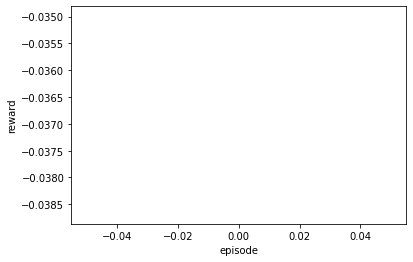

validate data reward


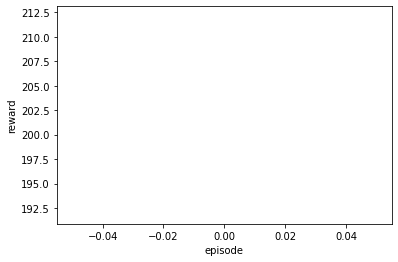

No handles with labels found to put in legend.


episode : 0
Get reward 49.0.
Trade count 21.
Tomorrow action : Action.STAY


<Figure size 432x288 with 0 Axes>

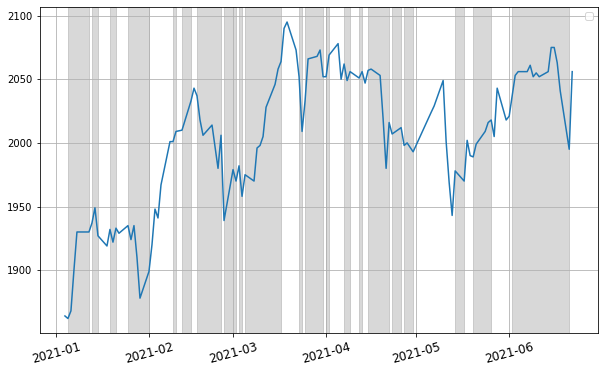

time : 19.809390783309937


In [8]:
# 1 episode 19s in mac

# lq.show_chart()
lq_dict = {}
episode_count=1
state='change_rate'
env_types = ['tanh']
start_time = time.time()
for env_type in env_types:
    for is_sarsa in [True]:
        lq = LearnQN()
        print("env type :",env_type)
        lq.learn_xqn(path_tpx,path_daw,state=state,env_type=env_type,episode_count=episode_count,train_year=2020,test_year=2021,is_sarsa=is_sarsa)
        lq_dict[env_type+str(is_sarsa)] = lq
        end_time = time.time()
print("time :",end_time -start_time)

In [20]:
lq_dict['tanhTrue'].QL_agent.model.summary()

# milestone

key : tanhTrue


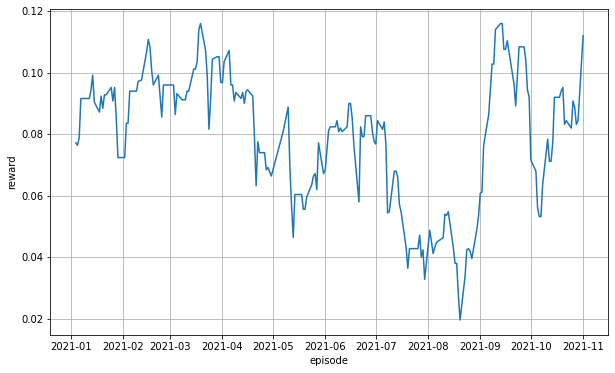

key : tanhFalse


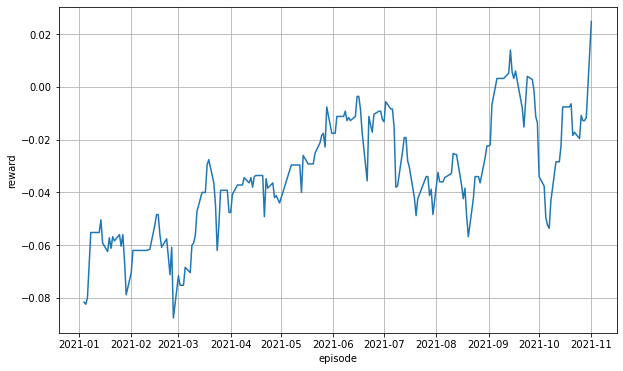

In [33]:
for i, key in enumerate(lq_dict):
    print("==========================")
    print('key :',key)
    pr = lq_dict[key].return_profit_rate(path_tpx_sim,path_daw_sim)
    pr = pr[pr.index.year==2021]
    easy_plot(pr['eval_reward'])
    

# 累積収益率
$$
累積収益率 = \frac{累積報酬}{元本}
$$

In [309]:

pr = lq.return_profit_rate(path_tpx_sim,path_daw_sim)
pr = pr[pr.index.year==2021]
# pr.plot()

reward


KeyError: 'ma'

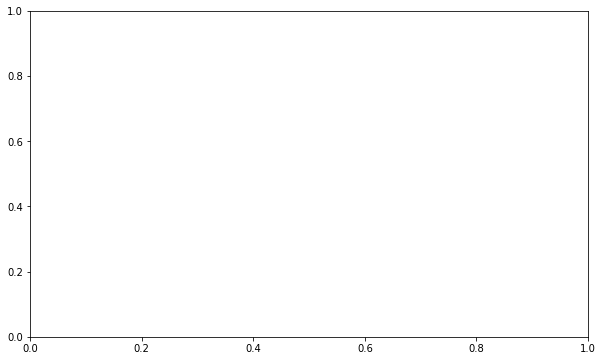

In [291]:
reward_log,test_reward_log = lq.return_reward_log()
print("reward")
reward_dict = make_plot_data(reward_log,ma=19)
plot(reward_dict)


test_reward


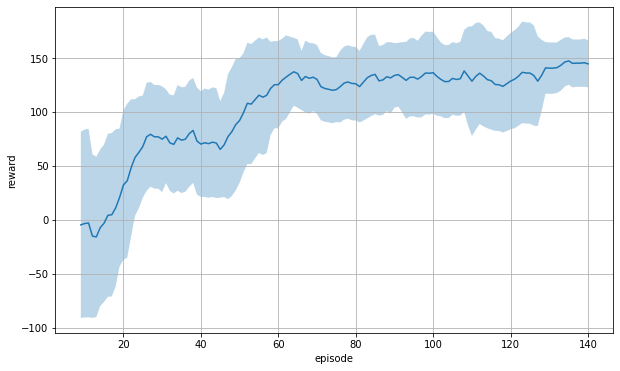

In [205]:
print("test_reward")
test_reward_dict = make_plot_data(test_reward_log,ma=19)
plot(test_reward_dict)

# Preict tomorrow

No handles with labels found to put in legend.


today : 2021-11-18 00:00:00
episode : 0
Get reward -5.0.
Trade count 6.
Tomorrow action : Action.BUY


<Figure size 432x288 with 0 Axes>

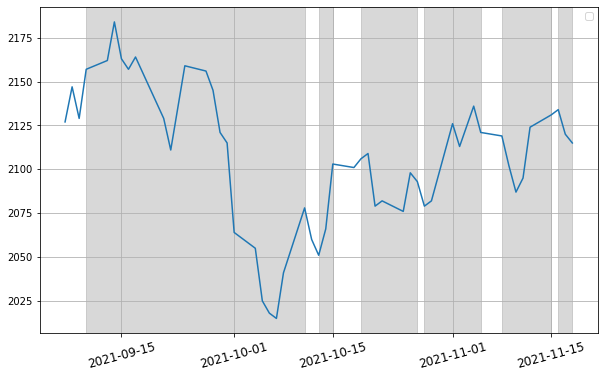

In [31]:
predict_tomorrow(lq_dict['tanhFalse'],folder_name='TOPIX')

# save model

In [135]:
save_path =  '/Users/rince/Desktop/Sotsuron/code/model/RL/Qagent/hoge'
lq.save(save_path)

# load model

---------------------
AUC train: 0.860577203982112
AUC test : 0.6767285722020684
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       219
           1       0.65      0.65      0.65       253

    accuracy                           0.63       472
   macro avg       0.63      0.63      0.63       472
weighted avg       0.63      0.63      0.63       472



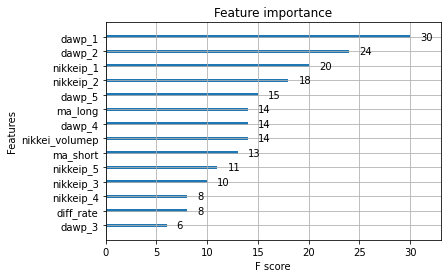

In [136]:
lq_copy = LearnQN.load(save_path+'hoge.pickle')

# 今後の方針

1. モデル別収益率返却関数の実装
2. シャープレシオ関数の実装
SharpRatio = (PrfitRate - const)\(Risk)
3. early_stopping機能の実装

# 累積収益率　比較

# Technical

In [32]:
path_tpx_sim = '/Users/rince/Desktop/StockPriceData/TOPIX/TOPIX_20211102.csv'
path_daw_sim = '/Users/rince/Desktop/StockPriceData/DAW/DAW_20211102.csv'

In [294]:
df_tpx = DataFramePreProcessing(path_tpx_sim).load_df()

<Figure size 432x288 with 0 Axes>

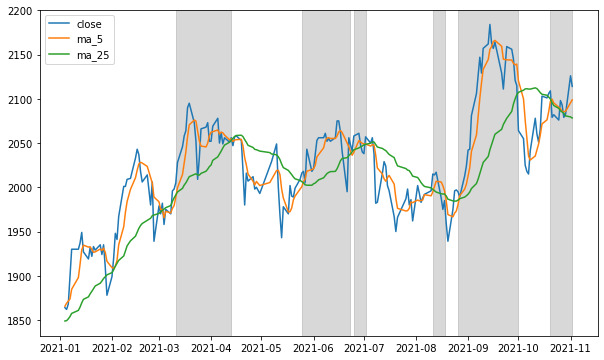

In [273]:
ts = TechnicalSimulation(hold_day=100,year=2021)
pr_log_t =  ts.return_profit_rate(path_tpx_sim)

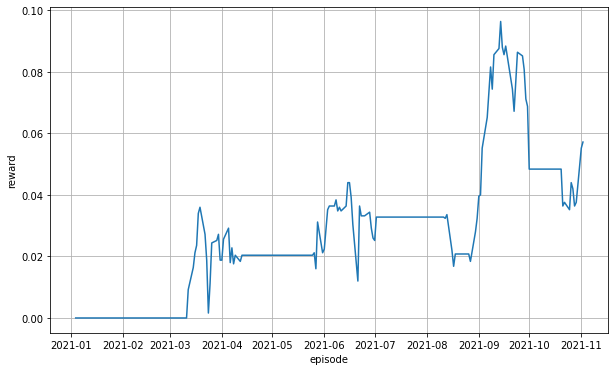

In [274]:

easy_plot(pr_log_t[pr_log_t.index.year==2021]['eval_reward'])

# TOPIX

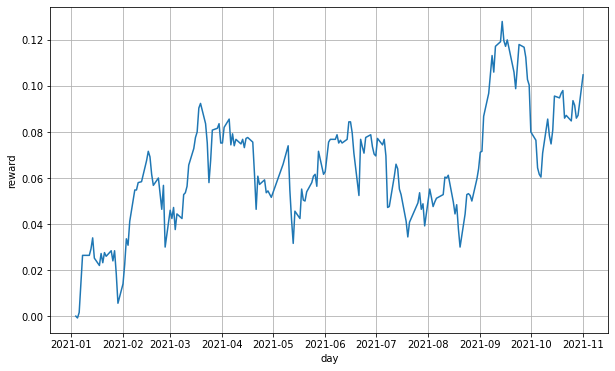

In [271]:
xs = XGBSimulation(lq.lx.model)
df_con = xs.make_df_con(path_tpx_sim,path_daw_sim)
df_con = df_con[df_con.index.year == 2021]
df_con['close']
pr_log_tpx = pd.DataFrame()
pr_log_tpx.index = df_con.index
wallet = 2500
pr_log_tpx['reward'] = df_con['close'].map(lambda x:x - df_con['close'].iloc[0])
pr_log_tpx['reward'] = pr_log_tpx['reward'].map(lambda x:x/wallet)
easy_plot(pr_log_tpx,xlabel='day')

# XGB

*************************
alpha : 0.5


No handles with labels found to put in legend.


Total profit :686.0
Trade count  :576
Max profit   :170.0
Min profit   :-92.0
Mean profit  :1.1909722222222223
      score  Up precision  Down precision  Up recall  Down recall     num
0  0.747034      0.741985        0.753333   0.789602      0.70062  2360.0



<Figure size 432x288 with 0 Axes>

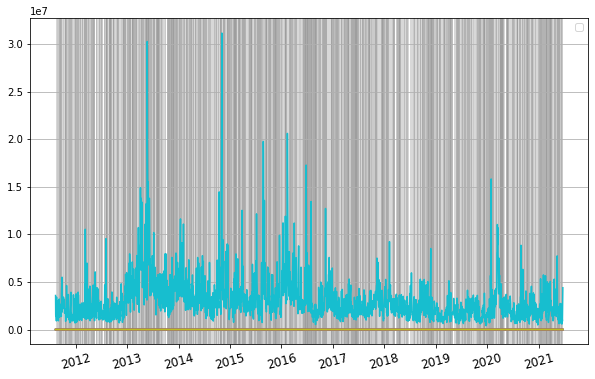

No handles with labels found to put in legend.
<ipython-input-276-4be54fa5dcb7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-276-4be54fa5dcb7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.6


No handles with labels found to put in legend.


Total profit :1010.0
Trade count  :338
Max profit   :184.0
Min profit   :-103.0
Mean profit  :2.9881656804733727
      score  Up precision  Down precision  Up recall  Down recall     num
0  0.837491       0.83697        0.838141    0.86587     0.804615  1403.0



<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

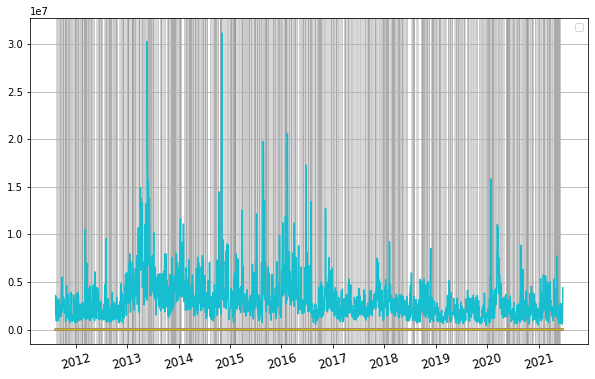

No handles with labels found to put in legend.
<ipython-input-276-4be54fa5dcb7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-276-4be54fa5dcb7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.7


No handles with labels found to put in legend.


Total profit :1117.0
Trade count  :213
Max profit   :186.0
Min profit   :-104.0
Mean profit  :5.244131455399061
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.901073       0.88764        0.916244   0.922897     0.878345  839.0



<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

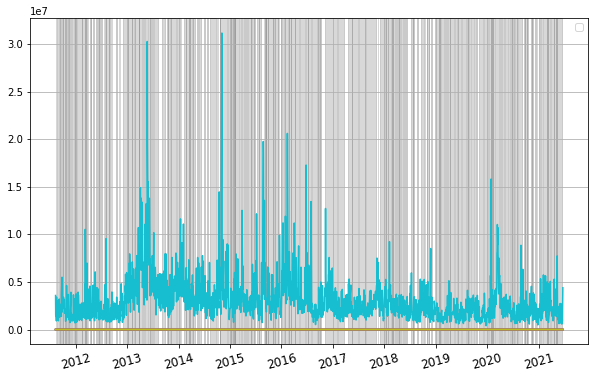

No handles with labels found to put in legend.
<ipython-input-276-4be54fa5dcb7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-276-4be54fa5dcb7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.8


No handles with labels found to put in legend.


Total profit :1359.0
Trade count  :106
Max profit   :214.0
Min profit   :-115.0
Mean profit  :12.820754716981131
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.939785      0.928287        0.953271   0.958848     0.918919  465.0



<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

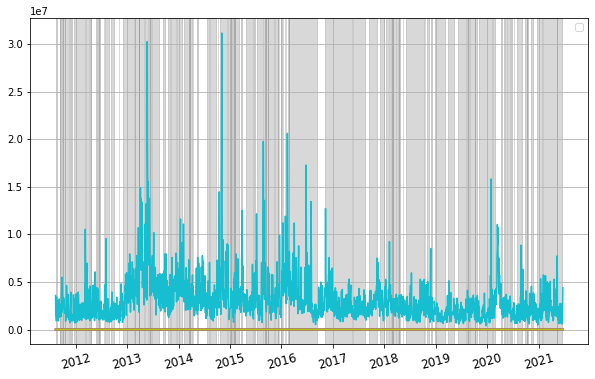

No handles with labels found to put in legend.
<ipython-input-276-4be54fa5dcb7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-276-4be54fa5dcb7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.9


No handles with labels found to put in legend.


Total profit :589.0
Trade count  :19
Max profit   :492.0
Min profit   :-306.0
Mean profit  :31.0
      score  Up precision  Down precision  Up recall  Down recall   num
0  0.977011      0.979167        0.974359   0.979167     0.974359  87.0



<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

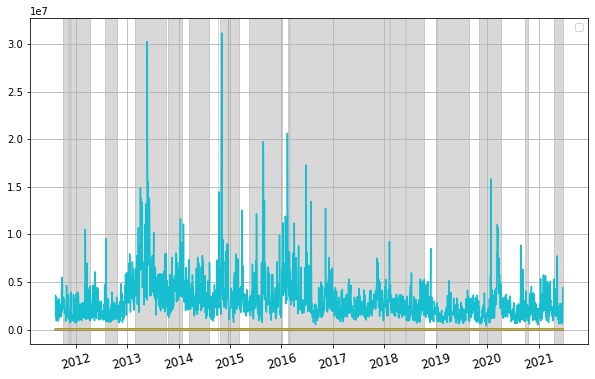

No handles with labels found to put in legend.
<ipython-input-276-4be54fa5dcb7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-276-4be54fa5dcb7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


<Figure size 432x288 with 0 Axes>

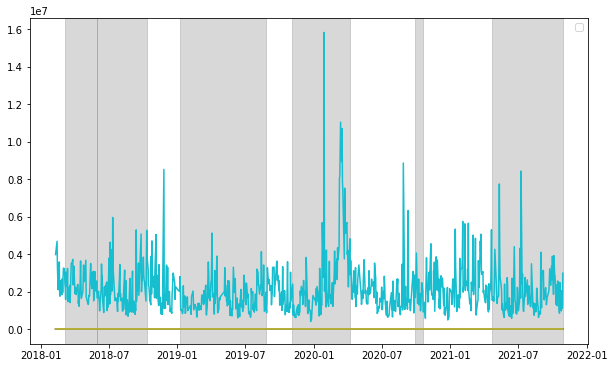

In [276]:
pr_log_xn = {}
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    print("*************************")
    print('alpha :',alpha)
    sl = XGBSimulation(lq.lx.model,alpha=alpha)
    sl.simulate(path_tpx, path_daw, is_validate=False,strategy='normal')
    pr_tmp = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=2500,strategy='normal')
    pr_tmp = pr_tmp[pr_tmp.index.year==2021]
    pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
    pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])
    pr_log_xn[alpha] = pr_tmp

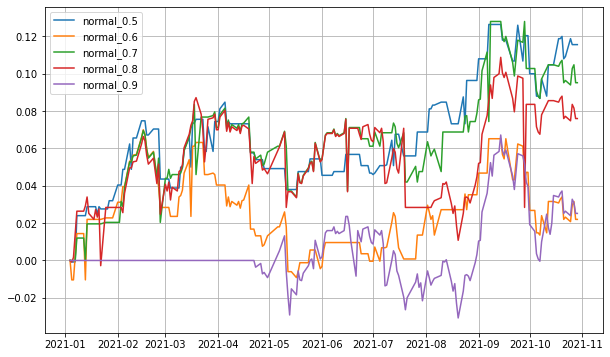

In [277]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_xn[0.5]['eval_reward'],label='normal_0.5')
plt.plot(pr_log_xn[0.6]['eval_reward'],label='normal_0.6')
plt.plot(pr_log_xn[0.7]['eval_reward'],label='normal_0.7')
plt.plot(pr_log_xn[0.8]['eval_reward'],label='normal_0.8')
plt.plot(pr_log_xn[0.9]['eval_reward'],label='normal_0.9')
plt.legend()
plt.grid(True)
plt.show()

*************************
alpha : 0.5


No handles with labels found to put in legend.


Total profit :537.0
Trade count  :577
Max profit   :116.0
Min profit   :-186.0
Mean profit  :0.9306759098786829
      score  Up precision  Down precision  Up recall  Down recall     num
0  0.747034      0.741985        0.753333   0.789602      0.70062  2360.0



<Figure size 432x288 with 0 Axes>

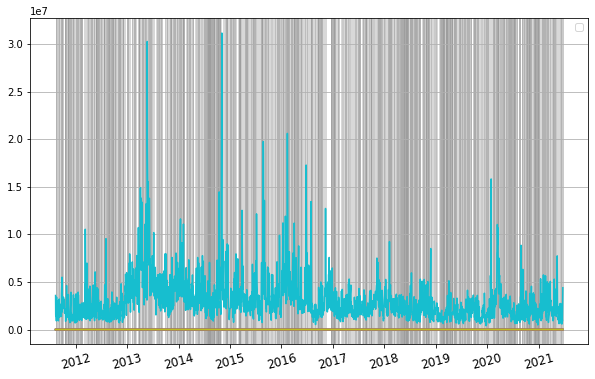

No handles with labels found to put in legend.
<ipython-input-279-e909452a84cc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-279-e909452a84cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.6


No handles with labels found to put in legend.


Total profit :213.0
Trade count  :339
Max profit   :116.0
Min profit   :-170.0
Mean profit  :0.6283185840707964
      score  Up precision  Down precision  Up recall  Down recall     num
0  0.837491       0.83697        0.838141    0.86587     0.804615  1403.0



<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

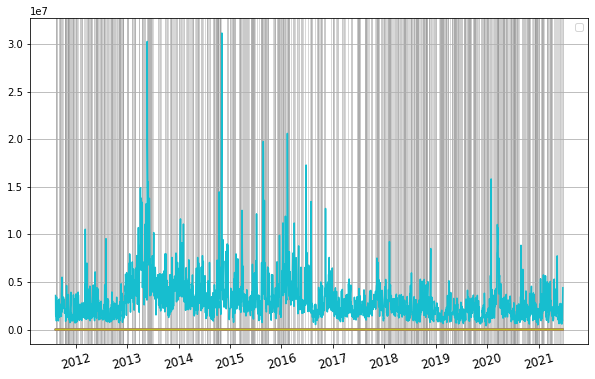

No handles with labels found to put in legend.
<ipython-input-279-e909452a84cc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-279-e909452a84cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.7


No handles with labels found to put in legend.


Total profit :106.0
Trade count  :214
Max profit   :140.0
Min profit   :-179.0
Mean profit  :0.4953271028037383
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.901073       0.88764        0.916244   0.922897     0.878345  839.0



<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

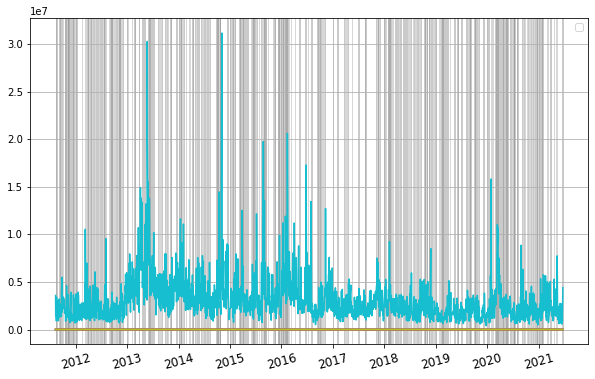

No handles with labels found to put in legend.
<ipython-input-279-e909452a84cc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-279-e909452a84cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.8


No handles with labels found to put in legend.


Total profit :-144.0
Trade count  :106
Max profit   :95.0
Min profit   :-163.0
Mean profit  :-1.3584905660377358
      score  Up precision  Down precision  Up recall  Down recall    num
0  0.939785      0.928287        0.953271   0.958848     0.918919  465.0



<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

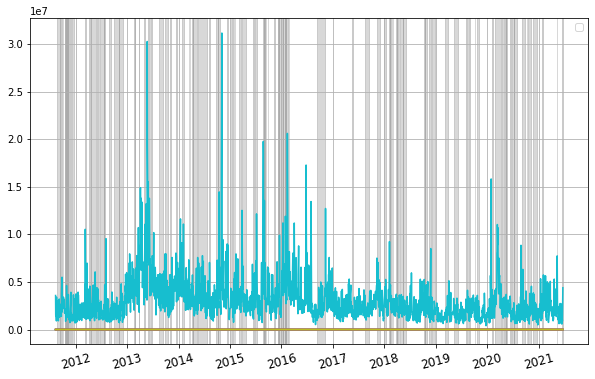

No handles with labels found to put in legend.
<ipython-input-279-e909452a84cc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-279-e909452a84cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


*************************
alpha : 0.9


No handles with labels found to put in legend.


Total profit :651.0
Trade count  :19
Max profit   :328.0
Min profit   :-193.0
Mean profit  :34.26315789473684
      score  Up precision  Down precision  Up recall  Down recall   num
0  0.977011      0.979167        0.974359   0.979167     0.974359  87.0



<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

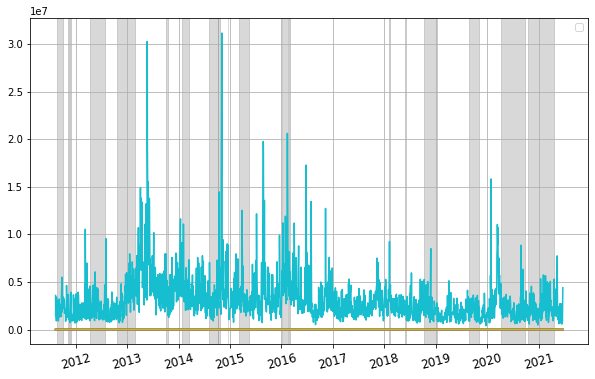

No handles with labels found to put in legend.
<ipython-input-279-e909452a84cc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
<ipython-input-279-e909452a84cc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])


<Figure size 432x288 with 0 Axes>

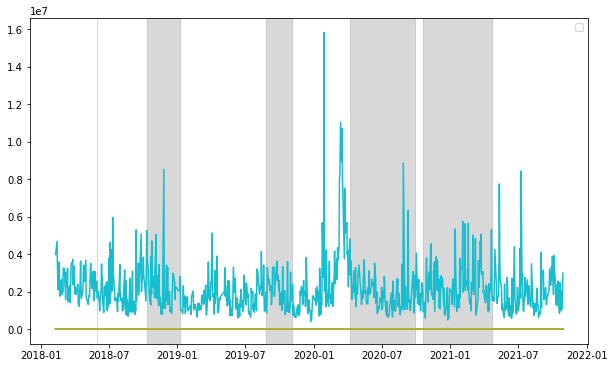

In [279]:
pr_log_xr = {}
for alpha in [0.5,0.6,0.7,0.8,0.9]:
    print("*************************")
    print('alpha :',alpha)
    sl = XGBSimulation(lq.lx.model,alpha=alpha)
    sl.simulate(path_tpx, path_daw, is_validate=False,strategy='reverse')
    pr_tmp = sl.return_profit_rate(path_tpx_sim,path_daw_sim,wallet=2500,strategy='reverse')
    pr_tmp = pr_tmp[pr_tmp.index.year==2021]
    pr_tmp['reward'] = pr_tmp['reward'].map(lambda x:x - pr_tmp['reward'].iloc[0])
    pr_tmp['eval_reward'] = pr_tmp['eval_reward'].map(lambda x:x - pr_tmp['eval_reward'].iloc[0])
    pr_log_xr[alpha] = pr_tmp

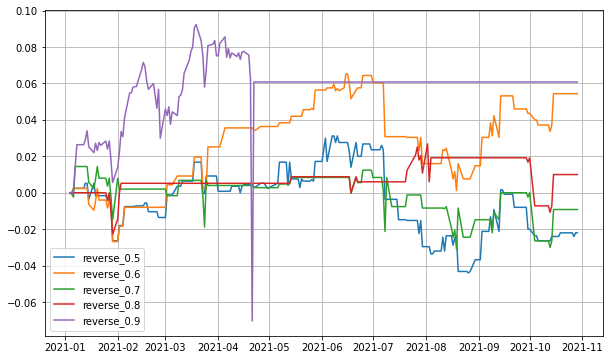

In [280]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_xr[0.5]['eval_reward'],label='reverse_0.5')
plt.plot(pr_log_xr[0.6]['eval_reward'],label='reverse_0.6')
plt.plot(pr_log_xr[0.7]['eval_reward'],label='reverse_0.7')
plt.plot(pr_log_xr[0.8]['eval_reward'],label='reverse_0.8')
plt.plot(pr_log_xr[0.9]['eval_reward'],label='reverse_0.9')
plt.legend()
plt.grid(True)
plt.show()

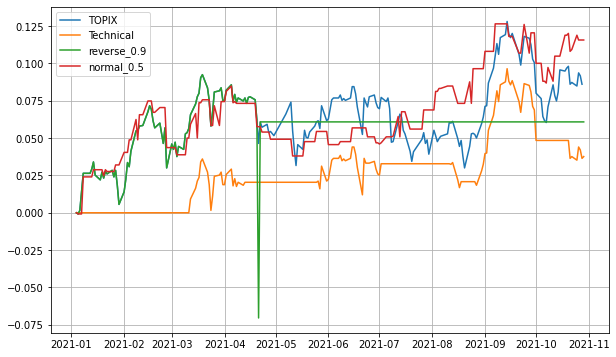

In [284]:
plt.subplots(figsize=(10, 6))
plt.plot(pr_log_tpx['reward'].iloc[:-2],label='TOPIX')
plt.plot(pr_log_t[pr_log_t.index.year==2021]['eval_reward'].iloc[:-2],label='Technical')
plt.plot(pr_log_xr[0.9]['eval_reward'],label='reverse_0.9')
plt.plot(pr_log_xn[0.5]['eval_reward'],label='normal_0.5')
plt.legend()
plt.grid(True)
plt.show()

In [196]:
len(pr_log_t[pr_log_t.index.year==2021].iloc[:-2])

203

In [195]:
len(pr_log_xr[0.5]['eval_reward'])

203

# Scaler

In [362]:
df_tpx = DataFramePreProcessing(path_tpx).load_df()

In [364]:
df_tpx.head()

,open,high,low,close,volume
day,,,,,
2011-06-23,849.0,855.0,848.0,851.0,1149460.0
2011-06-24,852.0,860.0,852.0,859.0,1527150.0
2011-06-27,857.0,857.0,849.0,852.0,6783400.0
2011-06-28,857.0,860.0,852.0,855.0,2429060.0
2011-06-29,866.0,869.0,863.0,868.0,1810540.0


In [372]:
scaler = StandardScaler() 
estimator = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1)
model = Pipeline([("scaler", scaler), ("estimator", estimator)])

states = df_tpx.values
scaled = model.named_steps["scaler"].fit(states).transform(states)


In [371]:
scaler.transform(states)

array([[-1.62193254, -1.6225093 , -1.60770311, -1.61657607, -0.81489361],
       [-1.61358142, -1.60862421, -1.59652576, -1.59429939, -0.64986528],
       [-1.59966289, -1.61695526, -1.60490878, -1.61379149,  1.64680705],
       ...,
       [ 1.75748663,  1.73212831,  1.72594352,  1.69707982, -0.93513547],
       [ 1.59324797,  1.57939232,  1.56387184,  1.56898892,  0.60278842],
       [ 1.6990288 ,  1.71824322,  1.70917748,  1.73884859, -0.09529073]])

In [377]:
a_ = np.array([[float(i) for i in range(3)] for j in range(2)])

In [378]:
a_

array([[0., 1., 2.],
       [0., 1., 2.]])

これ縦で標準化してる

In [380]:
# scaled = model.named_steps["scaler"].fit(a_).transform(a_)
scaled = scaler.transform(a_)
scaled

array([[0., 0., 0.],
       [0., 0., 0.]])

In [46]:
a_ = [1,2,3]
a_ = np.array(a_)

# scaled = scaler.transform(a_)
# scaled

In [47]:
a_

array([1, 2, 3])

In [48]:
preprocessing.scale(a_,axis=0)
# たて

array([-1.22474487,  0.        ,  1.22474487])

In [50]:
preprocessing.scale(a_,axis=1)
# ヨコ

array([-1.22474487,  0.        ,  1.22474487])

# Grid search

In [7]:
lx = LearnXGB()
x_train,y_train,x_test,y_test = lx.make_xgb_data(path_tpx,path_daw,test_rate=0.80)


In [15]:
grid_search(x_train,y_train,x_test,y_test)

# milestone

param1

In [13]:
{'eta': 0.10133010936006664, 'max_depth': 3, 'lambda': 0.7688766095080382, 'n_estimators': 4, 'reg_alpha': 0.5752333513767293, 'reg_lambda': 0.3639652652940705, 'importance_type': 'total_cover'}

{'eta': 0.10133010936006664,
 'max_depth': 3,
 'lambda': 0.7688766095080382,
 'n_estimators': 4,
 'reg_alpha': 0.5752333513767293,
 'reg_lambda': 0.3639652652940705,
 'importance_type': 'total_cover'}

param2

In [14]:
{'eta': 0.09596830907961507, 'max_depth': 3, 'lambda': 0.7357580506094586, 'n_estimators': 3, 'reg_alpha': 0.6480353642599526, 'reg_lambda': 0.48699139703134453, 'importance_type': 'total_cover'}

{'eta': 0.09596830907961507,
 'max_depth': 3,
 'lambda': 0.7357580506094586,
 'n_estimators': 3,
 'reg_alpha': 0.6480353642599526,
 'reg_lambda': 0.48699139703134453,
 'importance_type': 'total_cover'}

# param1

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


---------------------
AUC train: 0.719021775770242
AUC test : 0.678822170483874
              precision    recall  f1-score   support

           0       0.63      0.47      0.54       219
           1       0.63      0.76      0.69       253

    accuracy                           0.63       472
   macro avg       0.63      0.62      0.62       472
weighted avg       0.63      0.63      0.62       472



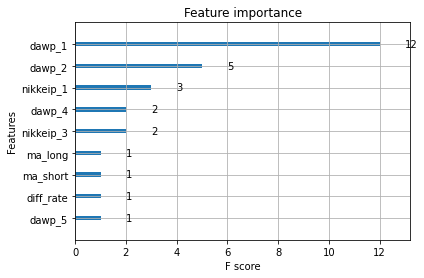

In [17]:
xgb_model = xgb_pred(x_train,y_train,x_test,y_test)

# param2

---------------------
AUC train: 0.7176032045663948
AUC test : 0.6818542783402819
              precision    recall  f1-score   support

           0       0.63      0.47      0.54       219
           1       0.63      0.76      0.69       253

    accuracy                           0.63       472
   macro avg       0.63      0.62      0.62       472
weighted avg       0.63      0.63      0.62       472



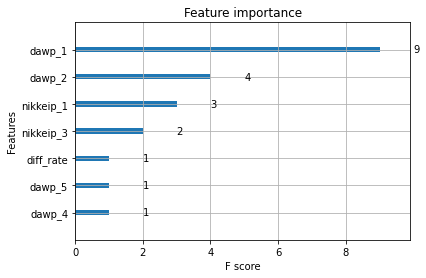

In [22]:
xgb_model = xgb_pred(x_train,y_train,x_test,y_test)

# Gridsearch の結果
param2の feature importanceからparam2の方がdawp1以外の特徴が活用されているため, param2を採用

#  新型earlystopping入れた方が良さそう

In [19]:
output_size = 3
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, input_shape=(4,),activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(output_size,activation='relu'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                50        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 33        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________
